In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

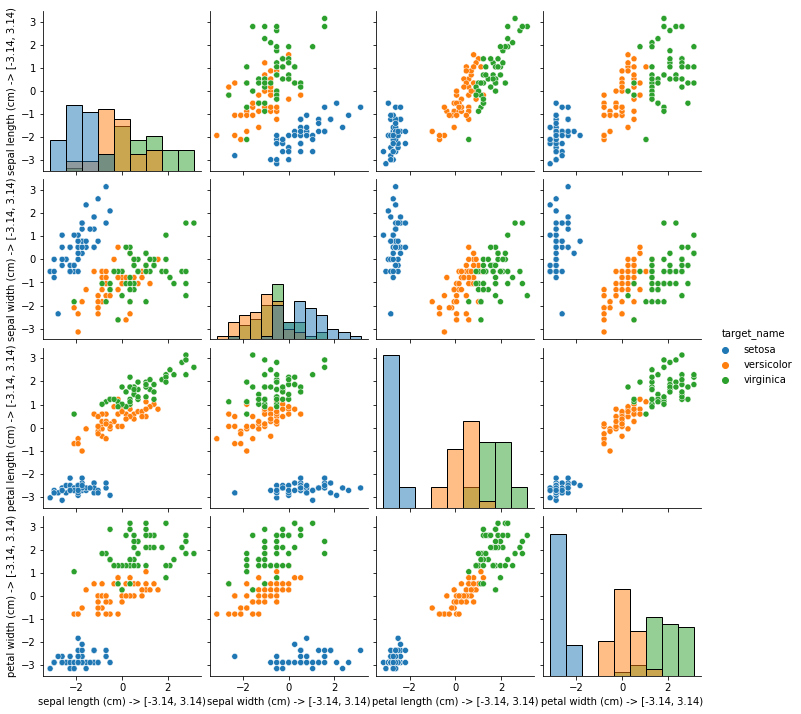

In [26]:
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.datasets import IrisDataset

ds = IrisDataset(feature_range=(-np.pi, np.pi))
ds.plot()

<BarContainer object of 50 artists>

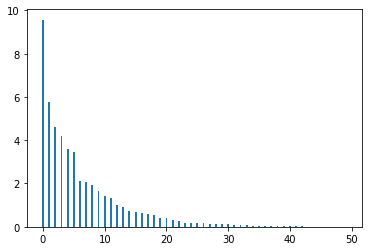

In [27]:
from classifiers.quantum.ansatz import Circuit9
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap

M=50
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.data, ds.target
X, y = ds.sample(M, return_X_y=True)
ind = np.argsort(y)
X, y = X[ind], y[ind]
X = X[:, :]


feature_map1 = Circuit9(X.shape[1], reps=1)
feature_map = feature_map1.copy()
for _ in range(2 - 1):
    feature_map.compose(feature_map1, inplace=True)

#feature_map = ZZFeatureMap(4, 2, entanglement='linear')
gamma = 0.9
def RBF(x, y):
    return np.exp(-np.linalg.norm(x-y)**2/2/gamma)

def make_kmatrix(X, Y, f):
    ret = []
    for x in X:
        tmp = []
        for y in Y:
            tmp.append(f(x, y))
        ret.append(tmp)
    return np.matrix(ret)

quantum_instance = QuantumInstance(backend=AerSimulator(method='statevector'), shots=2**13)
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
kernel_matrix = quantum_kernel.evaluate(x_vec=X)
# kernel_matrix =  make_kmatrix(X, X, RBF)
eigs = np.abs(np.linalg.eigvals(kernel_matrix))
plt.bar(np.arange(M), sorted(eigs, key=lambda x: -x), 0.3)

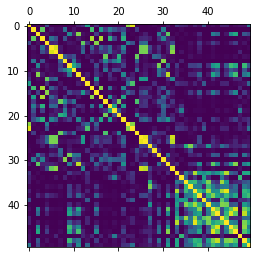

In [28]:
plt.matshow(kernel_matrix)

1.0


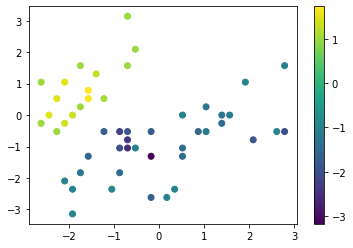

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(C=10**10, kernel='precomputed')
svm.fit(kernel_matrix, y)
c = svm.decision_function(kernel_matrix)
print(accuracy_score(y, svm.predict(kernel_matrix)))
plt.scatter(X[:,0], X[:, 1], c=c)
plt.colorbar()

In [30]:
from cvxopt import matrix, solvers
M = kernel_matrix.shape[0]
P = matrix(kernel_matrix)
q = matrix(np.zeros(M))
G = matrix(-np.eye(M))
h = matrix(np.zeros(M))
A = matrix(np.ones(M), (1, M))
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)
alpha = sol['x']
dval = 2*sol['dual objective']

     pcost       dcost       gap    pres   dres
 0:  6.1376e-02 -9.6471e-01  5e+01  7e+00  7e+00
 1:  6.7013e-02 -9.2060e-01  1e+00  5e-03  5e-03
 2:  6.6378e-02  5.1401e-03  6e-02  3e-04  3e-04
 3:  6.2160e-02  4.7925e-02  1e-02  3e-05  3e-05
 4:  5.9488e-02  5.6638e-02  3e-03  2e-06  2e-06
 5:  5.8404e-02  5.7996e-02  4e-04  3e-16  1e-16
 6:  5.8254e-02  5.8218e-02  4e-05  5e-17  1e-16
 7:  5.8238e-02  5.8236e-02  2e-06  2e-16  1e-16
 8:  5.8237e-02  5.8237e-02  7e-08  4e-17  1e-16
Optimal solution found.


In [31]:
def radious2(x):
    return np.asarray(1-2*alpha.H*matrix(np.abs(quantum_kernel.evaluate(X, x))**2)+dval)[0]
    return np.asarray(1-2*alpha.H*matrix(make_kmatrix(X, x, RBF))+dval)[0]
R2 = 1-dval

In [32]:
sv_ind = np.isclose(np.asarray(1-2*alpha.H*P + dval)[0], R2)
def radious2(x):
    return np.asarray(1-2*matrix(np.asarray(alpha)[sv_ind]).H*matrix(quantum_kernel.evaluate(X[sv_ind], x))+dval)[0]

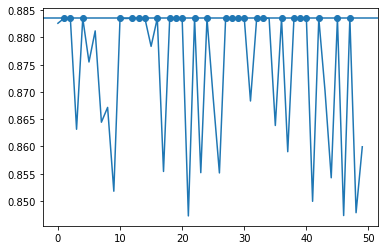

In [33]:
plt.plot(np.asarray(1-2*alpha.H*P + dval)[0])
plt.axhline(y=R2, xmin=0, xmax=M-1)
plt.scatter(np.where(sv_ind), np.asarray(1-2*alpha.H*P + dval)[0][sv_ind])

In [34]:
A = np.empty_like(kernel_matrix)
from itertools import product
from tqdm.notebook import tqdm
for i, j in tqdm(list(product(range(M), range(M)))):
    if i==j:
        A[i, j]=1
    elif i>j:
        tX = np.asanyarray([t*X[i]+(1-t)*X[j] for t in np.linspace(0, 1, 20)])
        ind = radious2(tX)
        if np.any(ind>R2):
            A[i, j]=0
            A[j, i]=0
        else:
            A[i, j]=1
            A[j, i]=1
    else:
        pass
A

  0%|          | 0/2500 [00:00<?, ?it/s]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

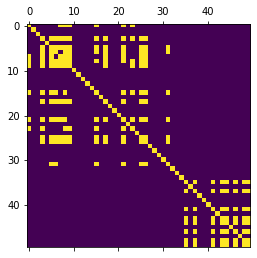

In [35]:
plt.matshow(A)

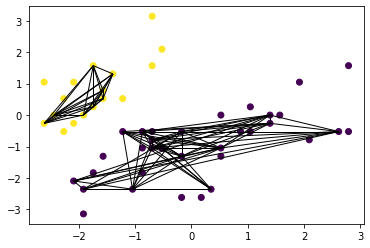

In [41]:
import networkx as nx 
G = nx.from_numpy_matrix(A)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=y)
nx.draw_networkx_edges(G, positions, ax=ax)

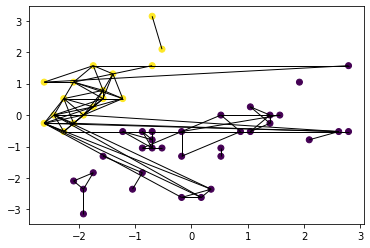

In [42]:
K2 = (kernel_matrix.flatten()>1-1/2*R2).reshape(M, M)
G = nx.from_numpy_matrix(K2)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=y)
nx.draw_networkx_edges(G, positions, ax=ax)

In [38]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, affinity='precomputed')
sc.fit(kernel_matrix)

SpectralClustering(affinity='precomputed', n_clusters=2)

In [39]:
sc.fit_predict(kernel_matrix)

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1], dtype=int32)

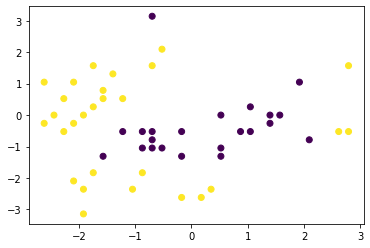

In [40]:
ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=sc.fit_predict(kernel_matrix))